In [1]:
from transformers import AutoTokenizer, BertForQuestionAnswering, BertModel, AutoModel
import torch
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

/Users/tanmaygoyal/opt/anaconda3/envs/pytorch_acc/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Getting Sentence embeddings from "all-mpnet-base-v2" and calculating cosine similarity

In [2]:
import torch.nn.functional as F

#Mean Pooling - Take attention mask into account for correct averaging
def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output[0] #First element of model_output contains all token embeddings
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9)


# Sentences we want sentence embeddings for
question = "he is a good man"
text = "he is a good man"
sentences = ["he is a good man", "he is a great man"]

# Load model from HuggingFace Hub
tokenizer = AutoTokenizer.from_pretrained('sentence-transformers/all-mpnet-base-v2')
model = AutoModel.from_pretrained('sentence-transformers/all-mpnet-base-v2')

# Tokenize sentences
encoded_input = tokenizer(sentences, padding=True, truncation=True, return_tensors='pt')

# Compute token embeddings
with torch.no_grad():
    model_output = model(**encoded_input)

# Perform pooling
sentence_embeddings = mean_pooling(model_output, encoded_input['attention_mask'])

# Normalize embeddings
sentence_embeddings = F.normalize(sentence_embeddings, p=2, dim=1)

print('Sentence Embeddings:', sentence_embeddings)
print('Cosine Similarity from embeddings generated by the model: {:4f}'.format(torch.cosine_similarity(sentence_embeddings[0].unsqueeze(0), sentence_embeddings[1].unsqueeze(0)).item()))

Sentence Embeddings: tensor([[ 0.0314,  0.0596,  0.0288,  ...,  0.0033,  0.0556,  0.0068],
        [ 0.0211,  0.0423,  0.0354,  ...,  0.0096,  0.0508, -0.0001]])
Cosine Similarity from embeddings generated by the model: 0.884947


### Calculating our similarity scores

In [3]:
def get_ticks_attention_scores(sentence1 , sentence2):
    model_version = 'sentence-transformers/all-mpnet-base-v2'
    model = AutoModel.from_pretrained(model_version, output_attentions=True, output_hidden_states=True)
    tokenizer = AutoTokenizer.from_pretrained(model_version)

    # generating the embeddings
    inputs = tokenizer(sentence1 , sentence2 , return_tensors='pt')
    input_ids = inputs['input_ids']
    attention = model(input_ids)[-1]
    input_id_list = input_ids[0].tolist() # Batch index 0
    tokens = tokenizer.convert_ids_to_tokens(input_id_list) 

    # generating the ticks
    ticks = []
    for j in range(len(inputs.input_ids)):
        for i in range(len(inputs.input_ids[j])):
            ticks.append(tokenizer.decode(inputs.input_ids[0][i]))

    # generating the attention matrix
    attention_tensors = []
    for tensor in model(input_ids).attentions:
        attention_tensors.append(tensor.detach().numpy())
    attentions_temp = torch.tensor(np.array(attention_tensors))
    
    return attentions_temp , ticks

In [4]:
def get_word_idx(sent: str, word: str):
    return sent.split(" ").index(word)
 
 
def get_hidden_states(encoded, token_ids_word, model, layers):
    """Push input IDs through model. Stack and sum `layers` (last four by default).
        Select only those subword token outputs that belong to our word of interest
        and average them."""
    with torch.no_grad():
        output = model(**encoded)
 
    # Get all hidden states
    states = output.hidden_states
    # Stack and sum all requested layers
    output = torch.stack([states[i] for i in layers]).sum(0).squeeze()
    # Only select the tokens that constitute the requested word
    word_tokens_output = output[token_ids_word]
 
    return word_tokens_output.mean(dim=0)
 
 
def get_word_vector(sent, idx, tokenizer, model, layers):
    """Get a word vector by first tokenizing the input sentence, getting all token idxs
        that make up the word of interest, and then `get_hidden_states`."""
    encoded = tokenizer.encode_plus(sent, return_tensors="pt")
    # get all token idxs that belong to the word of interest
    token_ids_word = np.where(np.array(encoded.word_ids()) == idx)
 
    return get_hidden_states(encoded, token_ids_word, model, layers)
 
 
def get_BERT_embeddings(layers , sent1 , sent2):
    # Use last four layers by default
    layers = [-4, -3, -2, -1] if layers is None else layers
    tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
    model = AutoModel.from_pretrained("bert-base-uncased", output_hidden_states=True)

    sent1_embeddings = []
    sent2_embeddings = []
    for w in sent1.split(" "):
        sent1_embeddings.append(get_word_vector(sent1, get_word_idx(sent1, w), tokenizer, model, layers))
    for w in sent2.split(" "):
        sent2_embeddings.append(get_word_vector(sent2 , get_word_idx(sent2, w), tokenizer, model, layers))
    # print(type(sent1_embeddings), type(sent2_embeddings), type(sent1_embeddings[0]))
    return sent1_embeddings, sent2_embeddings 

def get_Word2Vec_embeddings(sent1 , sent2):
    from gensim.models import Word2Vec
    from gensim.models import KeyedVectors
    import gensim.downloader as api
    word_vectors = api.load("word2vec-google-news-300")
    sent1_embeddings = []
    sent2_embeddings = []
    for w in sent1.split(" "):
        sent1_embeddings.append(torch.tensor(word_vectors[w]))
    for w in sent2.split(" "):
        sent2_embeddings.append(torch.tensor(word_vectors[w]))
    return sent1_embeddings, sent2_embeddings


def get_glove_embeddings(sent1 , sent2):
    from gensim.models import Word2Vec
    from gensim.models import KeyedVectors
    import gensim.downloader as api
    word_vectors = api.load("glove-wiki-gigaword-100")
    sent1_embeddings = []
    sent2_embeddings = []
    for w in sent1.split(" "):
        sent1_embeddings.append(torch.tensor(word_vectors[w]))
    for w in sent2.split(" "):
        sent2_embeddings.append(torch.tensor(word_vectors[w]))
    return sent1_embeddings, sent2_embeddings


In [20]:
def get_scores(attention_matrix , s1_embeddings , s2_embeddings):
    sum = 0
    len_s1 = attention_matrix.shape[0]-2 # to account for the [SEP]
    len_s2 = attention_matrix.shape[1]-2 # to account foe the [SEP]

    if len(s1_embeddings) != len_s1 or len(s2_embeddings) != len_s2:
        print("Incorrect dimensions of embeddings or attention matrix")
        print("s1_embeddings: ", len(s1_embeddings))
        print("s2_embeddings: ", len(s2_embeddings))
        print("attention_matrix: ", attention_matrix.shape)
        return
    
    for i in range(len_s1):
        correct_idx = i+1 # since we have [SEP] at 0 index
        attention = attention_matrix[correct_idx]
        most_attention = np.argmax(attention)
        if most_attention in [0 , len(attention)-1]:
            continue # most attention was given to [SEP]
        else:
            most_attention_correct_idx = most_attention - 1  # since 0 index is SEP
            sum += torch.cosine_similarity(s1_embeddings[i].unsqueeze(0) , s2_embeddings[most_attention_correct_idx].unsqueeze(0)).item()

    full_score =sum / len_s1

    return full_score


In [21]:
def similarity_score(sentence1 , sentence2 , plot_attention = True, embeddings='glove'):
    '''
    Function to calculate the similarity score between two sentences
    Parameters:
    sentence1 : sentence 1
    sentence2 : sentence 2
    plot_attention : Whether to plot the attention matrix or not    
    '''

    
    sentence1 = sentence1.lower()
    sentence2 = sentence2.lower()


    attention_matrix , ticks = get_ticks_attention_scores(sentence1 , sentence2)
    if embeddings == 'bert':
        embeddings_s1 , embeddings_s2 = get_BERT_embeddings(None , sentence1 , sentence2)
    if embeddings == 'word2vec':
        embeddings_s1 , embeddings_s2 = get_Word2Vec_embeddings(sentence1 , sentence2)
    if embeddings == 'glove':
        embeddings_s1 , embeddings_s2 = get_glove_embeddings(sentence1 , sentence2)
    # embeddings_s1 , embeddings_s2 = get_Word2Vec_embeddings(sentence1 , sentence2)
    
    sep_indices = [i for i in range(len(ticks)) if ticks[i] in ["<s>" , "</s>"]]
    if len(sep_indices) != 4:
        print("Incorrect number of [SEP] tokens")
        return
    
    sentence_divider = sep_indices[1]

    relevant_attention_matrix = []
    # for A->B
    relevant_attention_matrix.append(attention_matrix.mean(axis=2)[-1][0][:sentence_divider+1,sentence_divider+1:])
    # for B->A
    relevant_attention_matrix.append(attention_matrix.mean(axis=2)[-1][0][sentence_divider+1:,:sentence_divider+1])
    
    if plot_attention:
        plt.figure(figsize=(20,10))
        plt.subplot(1,2,1)
        plt.title("Attention from Reference -> Generated")
        sns.heatmap(relevant_attention_matrix[0],xticklabels = ticks[sentence_divider+1:] , yticklabels = ticks[:sentence_divider+1], annot=True)
        plt.subplot(1,2,2)
        plt.title("Attention Matrix from Generated -> Reference")
        sns.heatmap(relevant_attention_matrix[1],xticklabels = ticks[:sentence_divider+1] , yticklabels = ticks[sentence_divider+1:], annot=True)
        plt.show()

    # getting the scores
    return max(get_scores(relevant_attention_matrix[0] , embeddings_s1 , embeddings_s2) , get_scores(relevant_attention_matrix[1] , embeddings_s2 , embeddings_s1))

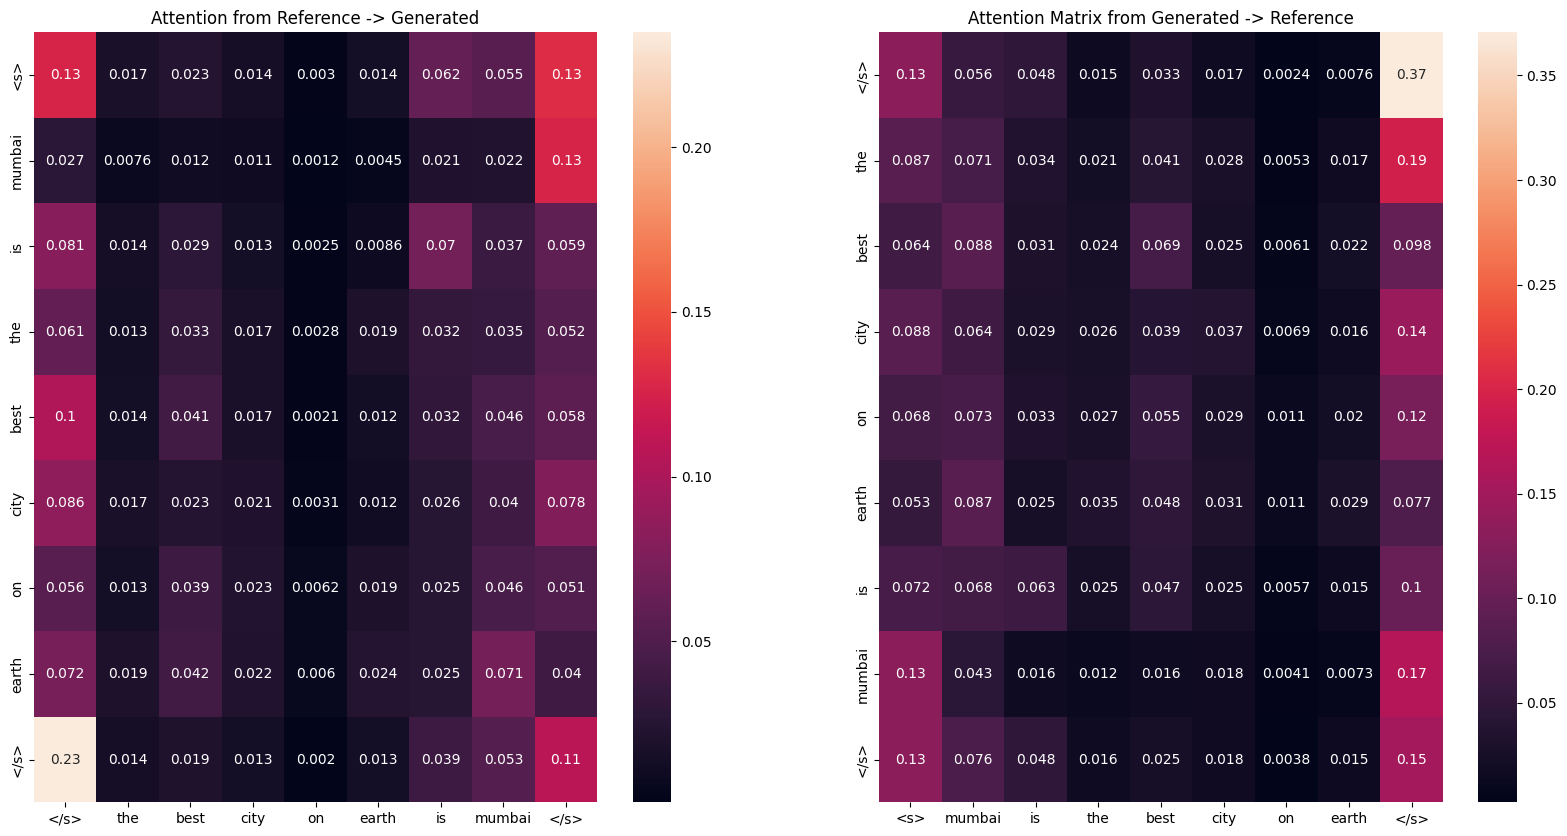

0.013691787208829607

In [22]:
similarity_score("Mumbai is the best city on earth" , "the best city on earth is mumbai")

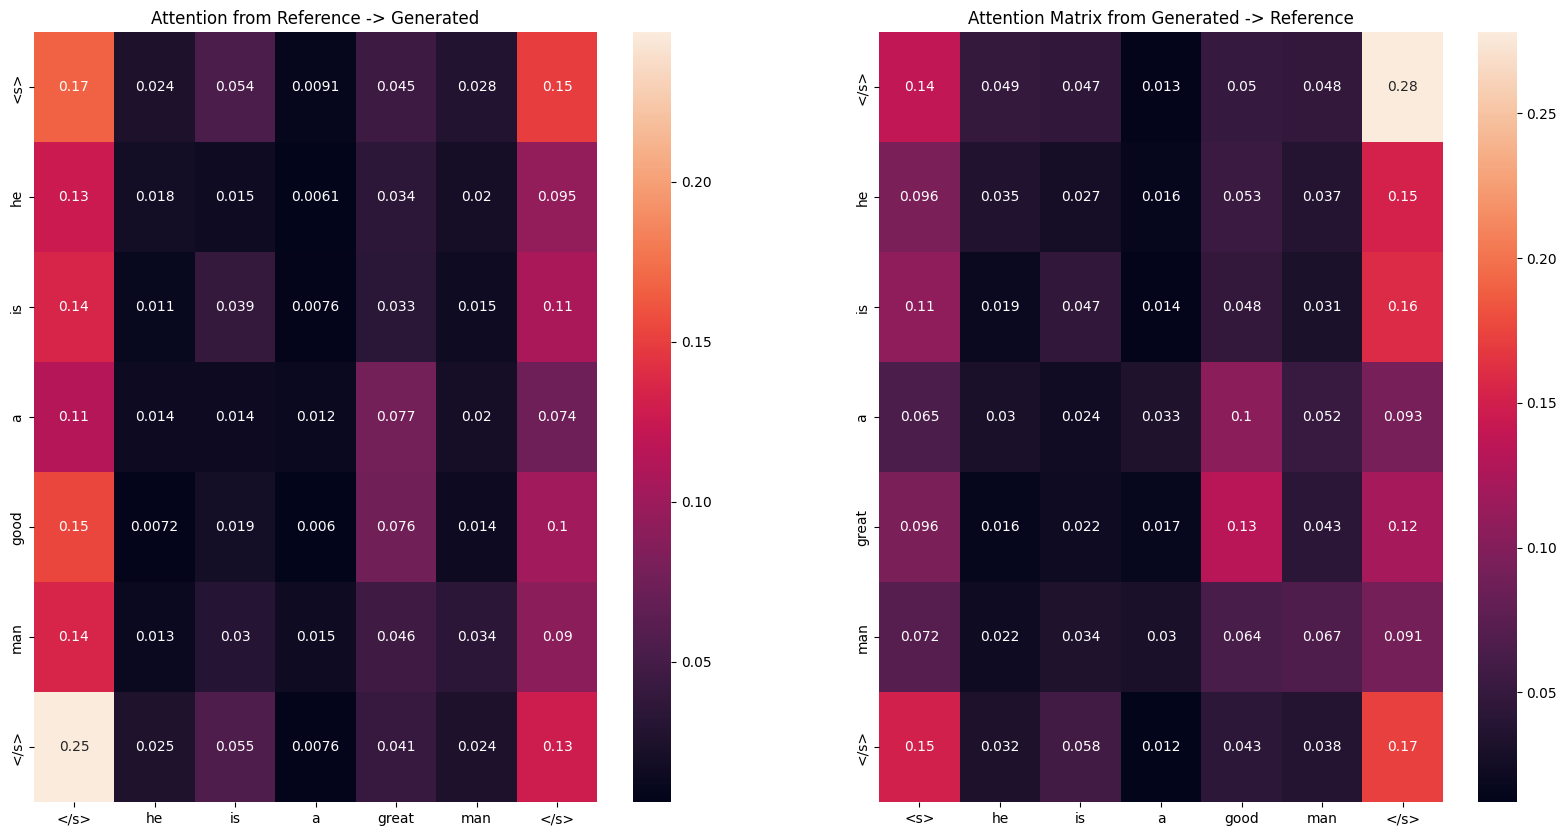

0.28459025621414186

In [23]:
similarity_score("He is a good man" , "He is a great man")

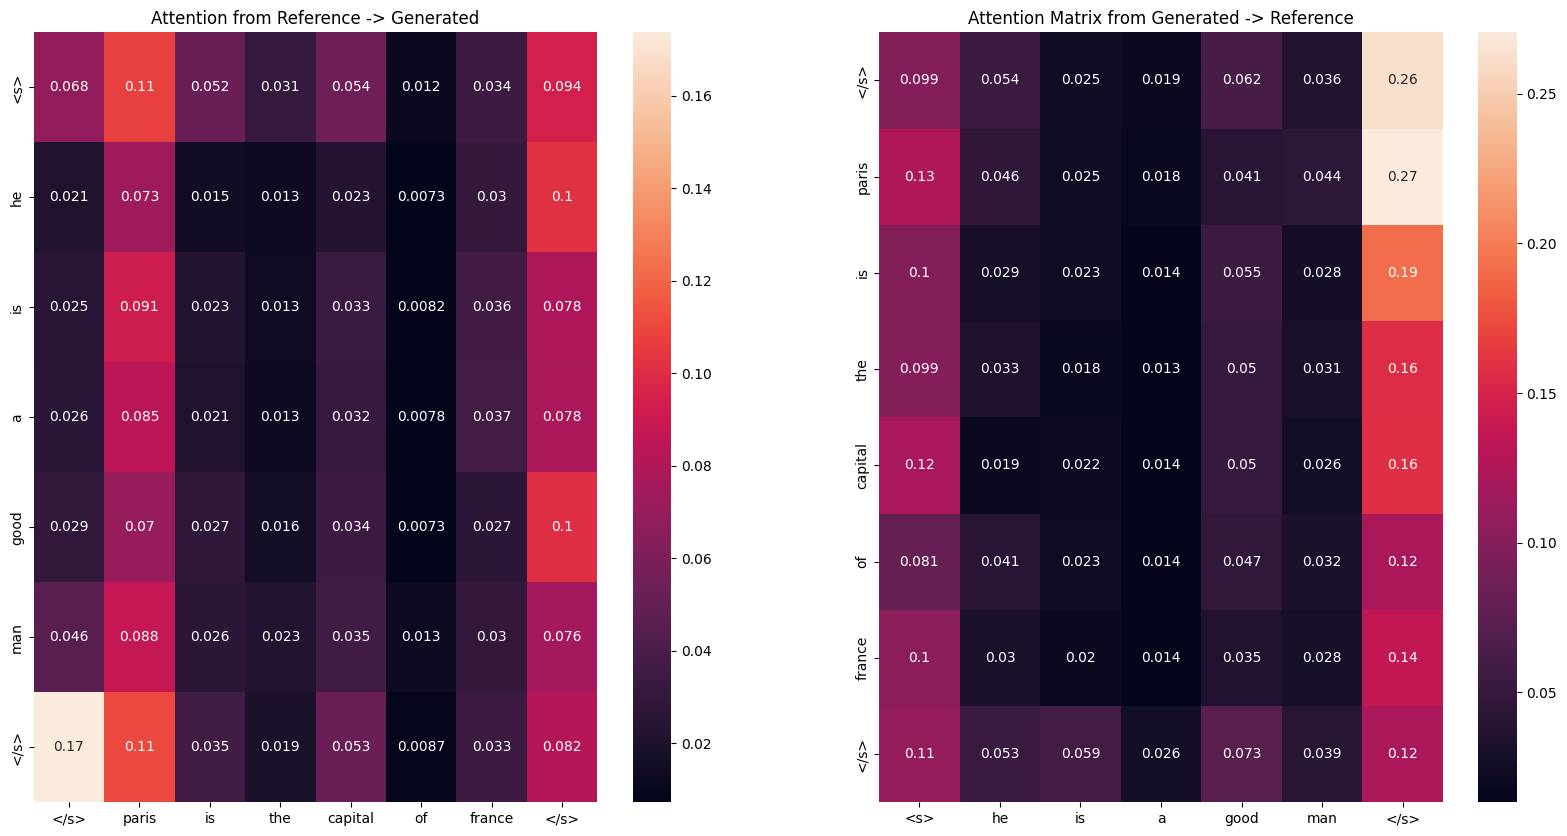

0.22590032815933228

In [24]:
similarity_score("he is a good man" , "paris is the capital of france")

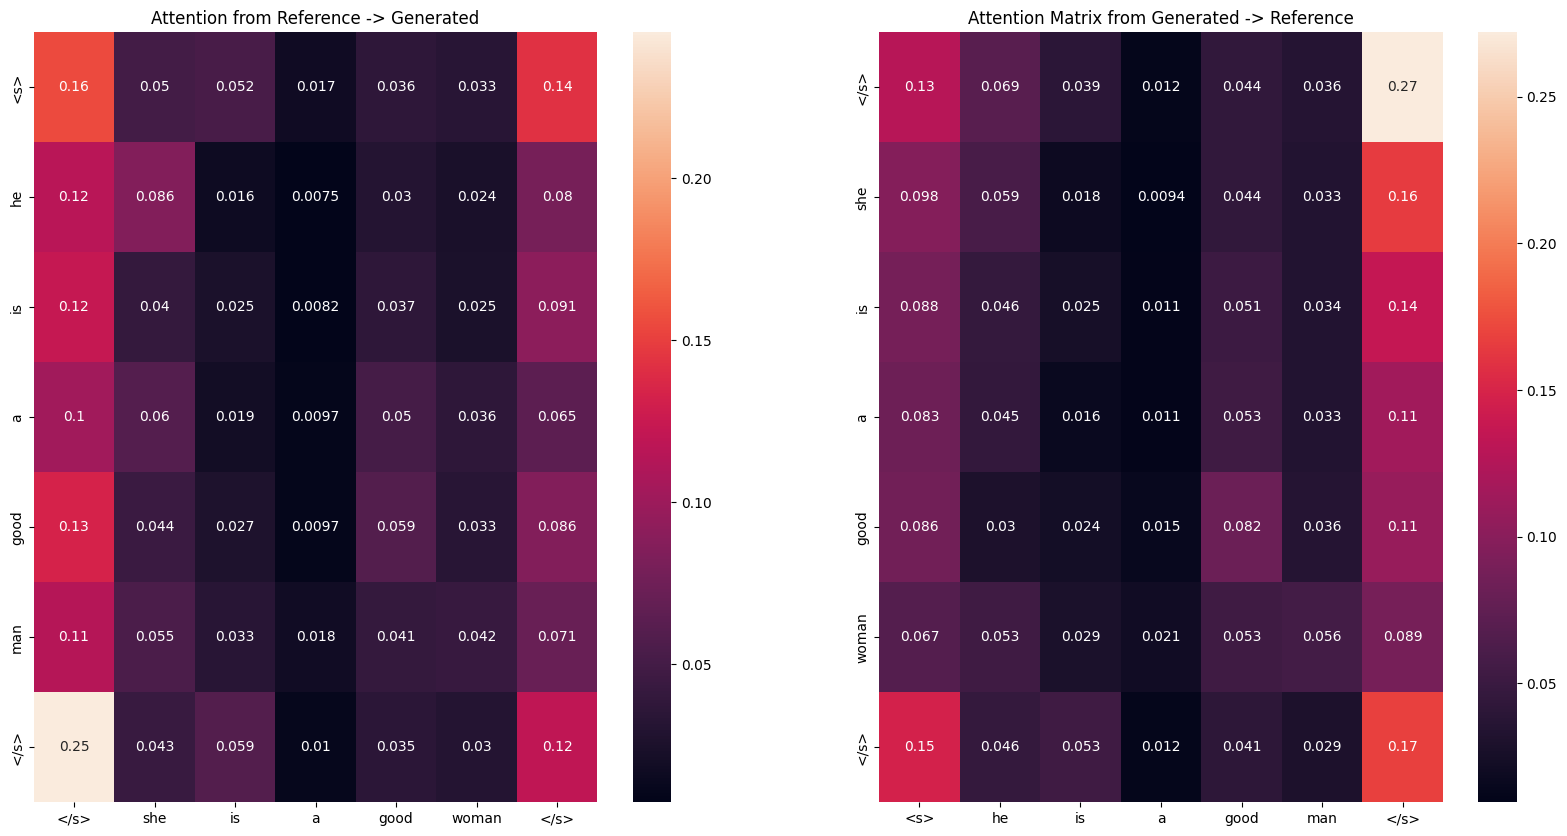

0.0

In [25]:
similarity_score("he is a good man" , "she is a good woman")

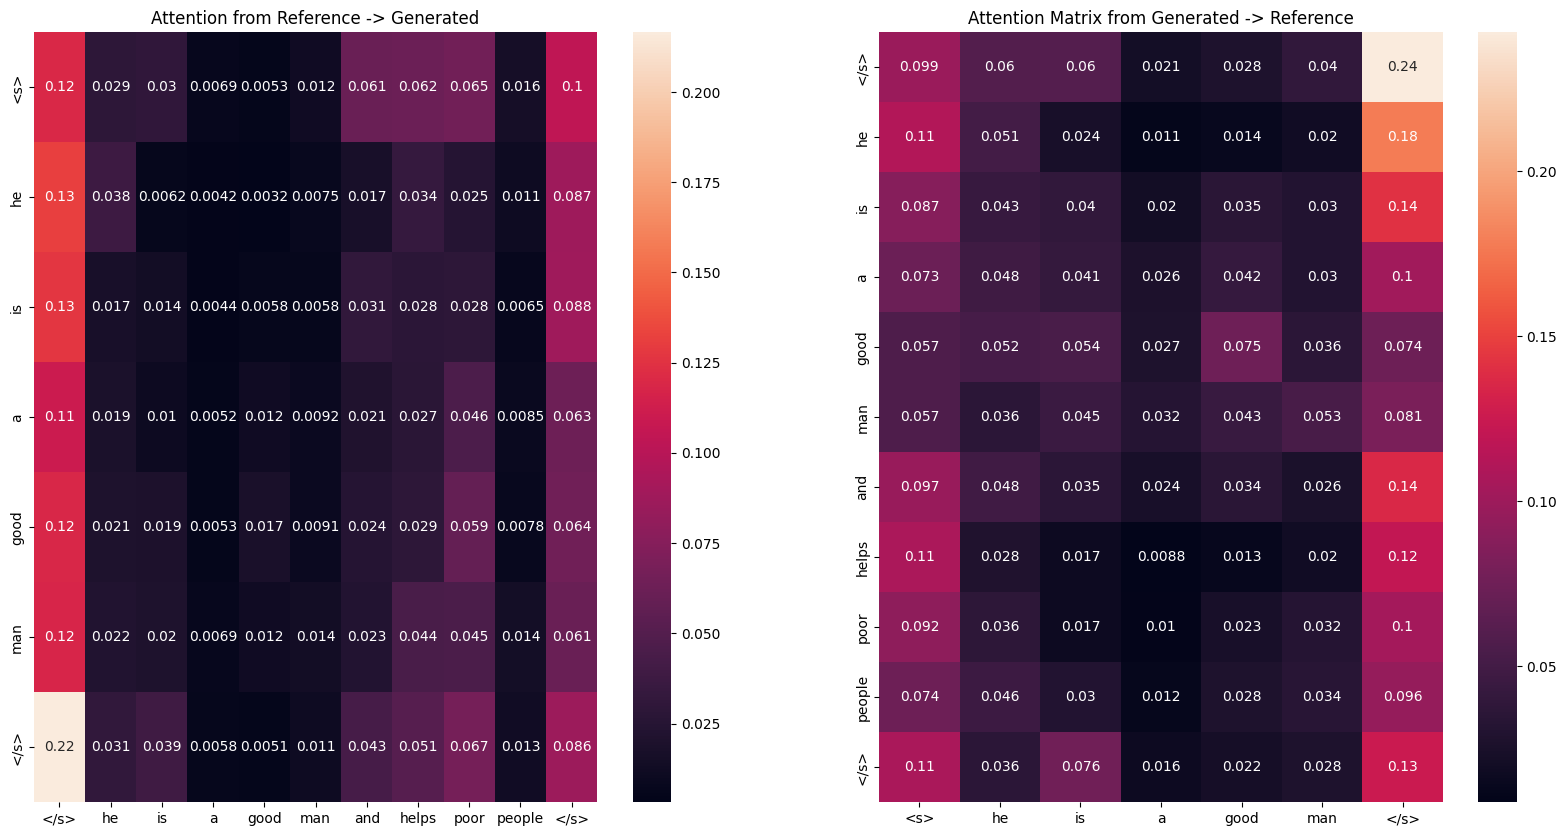

0.11111112435658772

In [26]:
similarity_score("he is a good man" , "he is a good man and helps poor people")

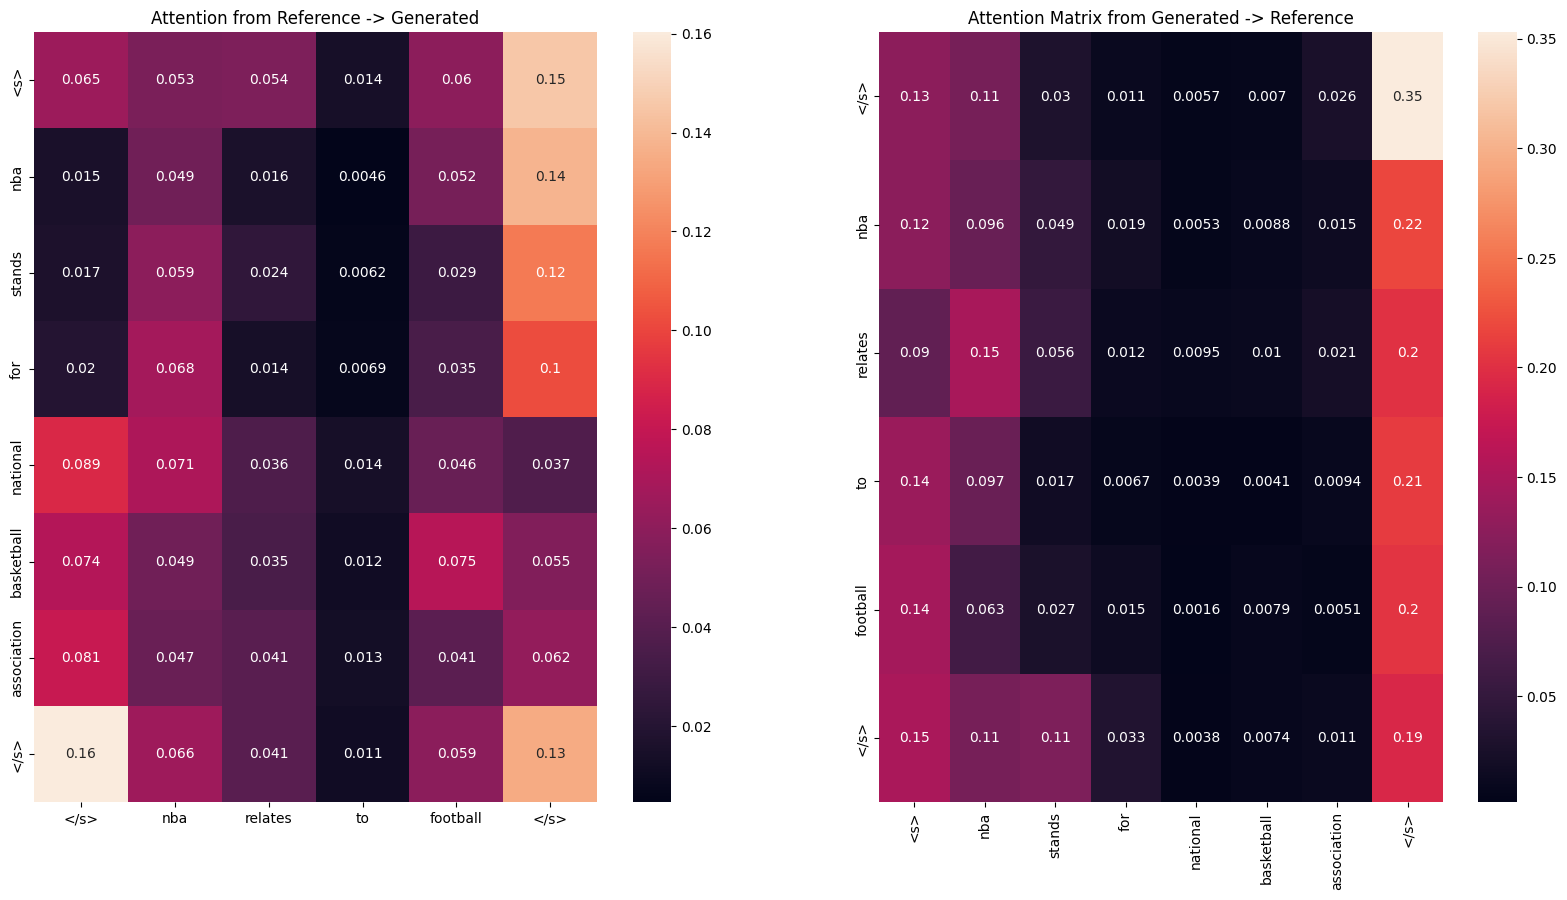

0.14259395996729532

In [27]:
similarity_score("nba stands for national basketball association" , "nba relates to football")

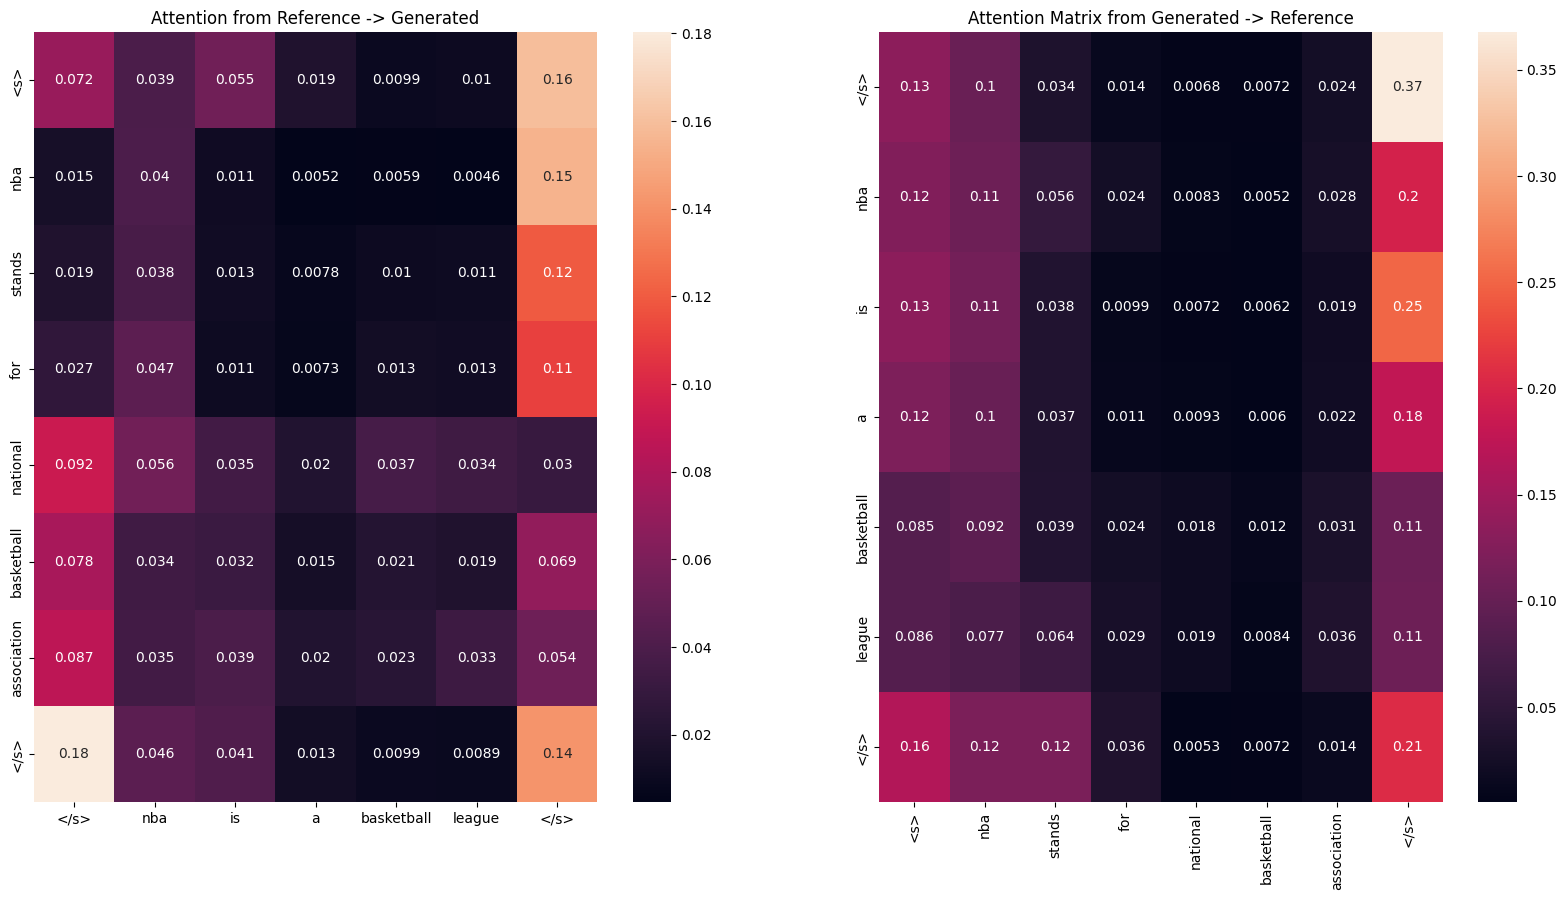

0.0

In [28]:
similarity_score("nba stands for national basketball association" , "nba is a basketball league")

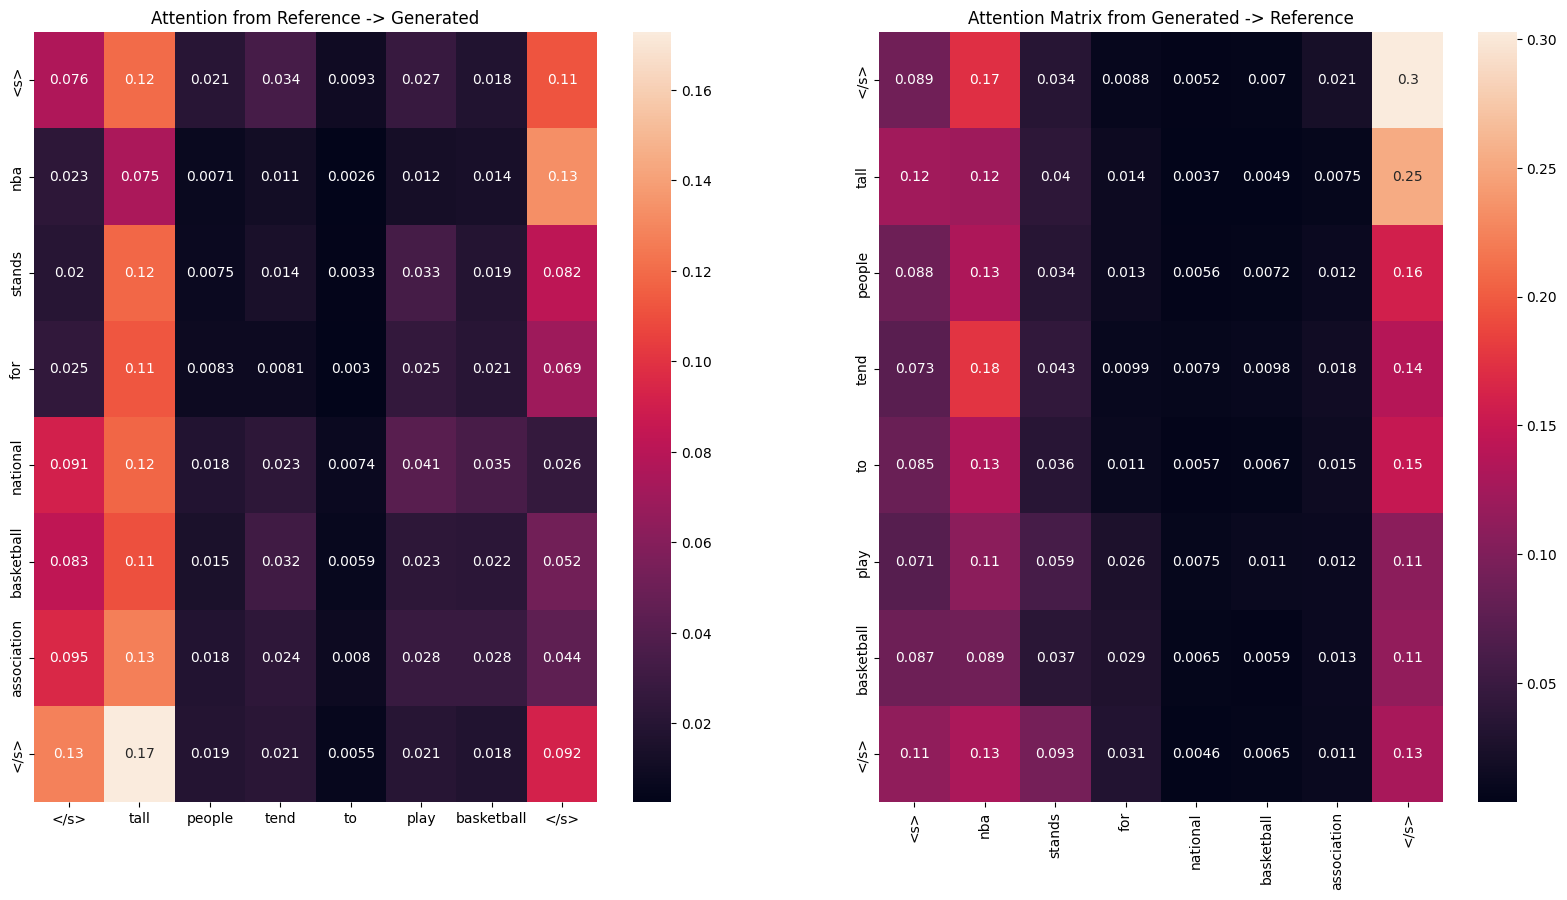

0.21851713582873344

In [29]:
similarity_score("nba stands for national basketball association" , "tall people tend to play basketball")

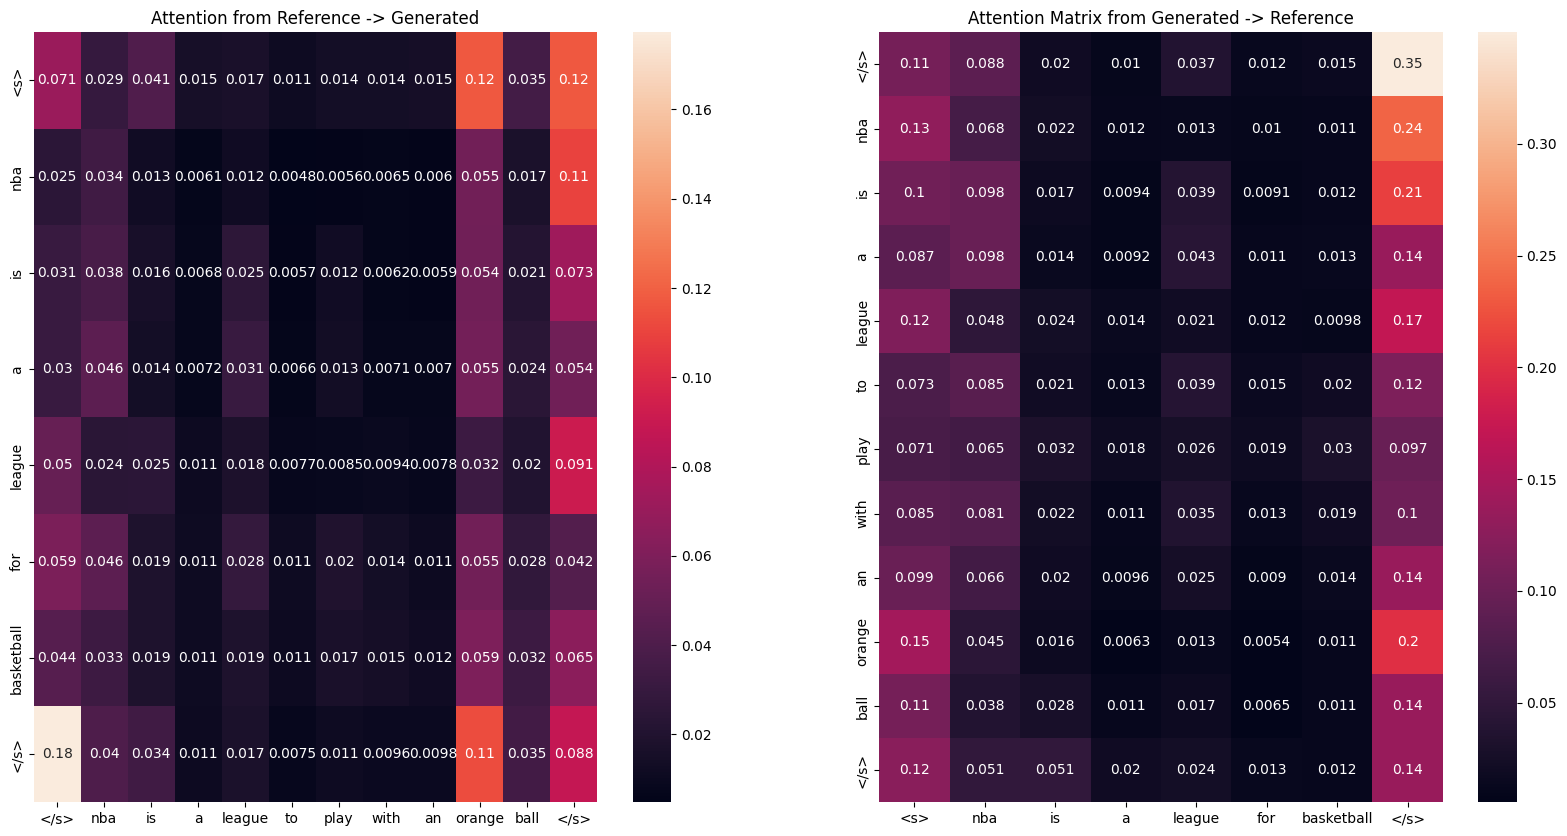

0.07374020417531331

In [30]:
similarity_score("nba is a league for basketball" , "nba is a league to play with an orange ball")